In [12]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Helper function for score aggregation
def aggregate_classes(score):
    if score < 55:
        return "Below 55"
    elif score <= 60:
        return "55-60"
    elif score <= 65:
        return "61-65"
    elif score <= 70:
        return "66-70"
    elif score <= 75:
        return "71-75"
    elif score <= 80:
        return "76-80"
    else:
        return "81+"

In [14]:
# Load and preprocess data
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score'].map(aggregate_classes)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [15]:
# Apply SMOTE for balanced dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [17]:
# Define parameter grid for MLP
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500]
}

In [18]:
# Initialize and train MLP with GridSearchCV
mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 50)],
                         'learning_rate_init': [0.001, 0.01],
                         'max_iter': [500]},
             scoring='f1_weighted')

In [19]:
# Get best model and make predictions
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print("\nFinal Model Performance (MLP):")
print(classification_report(y_test, y_pred))
print(f"Final Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'max_iter': 500}

Final Model Performance (MLP):
              precision    recall  f1-score   support

       55-60       0.99      1.00      1.00       656
       61-65       0.96      0.96      0.96       733
       66-70       0.94      0.89      0.91       635
       71-75       0.95      0.97      0.96       664
       76-80       1.00      1.00      1.00       715
         81+       0.98      1.00      0.99       669

    accuracy                           0.97      4072
   macro avg       0.97      0.97      0.97      4072
weighted avg       0.97      0.97      0.97      4072

Final Test Set Accuracy: 0.9708


In [20]:
# Visualization functions
def plot_class_distribution():
    plt.figure(figsize=(15, 5))
    
    # Before SMOTE
    plt.subplot(1, 2, 1)
    initial_distribution = y.value_counts().sort_index()
    plt.bar(initial_distribution.index, initial_distribution.values)
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # After SMOTE
    plt.subplot(1, 2, 2)
    balanced_distribution = pd.Series(y_balanced).value_counts().sort_index()
    plt.bar(balanced_distribution.index, balanced_distribution.values)
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance():
    plt.figure(figsize=(12, 6))
    feature_importance = np.abs(best_mlp.coefs_[0]).mean(axis=1)
    feature_importance = pd.Series(feature_importance, index=X.columns)
    feature_importance.sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature Importance in MLP (Based on First Layer Weights)')
    plt.xlabel('Average Absolute Weight')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix():
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

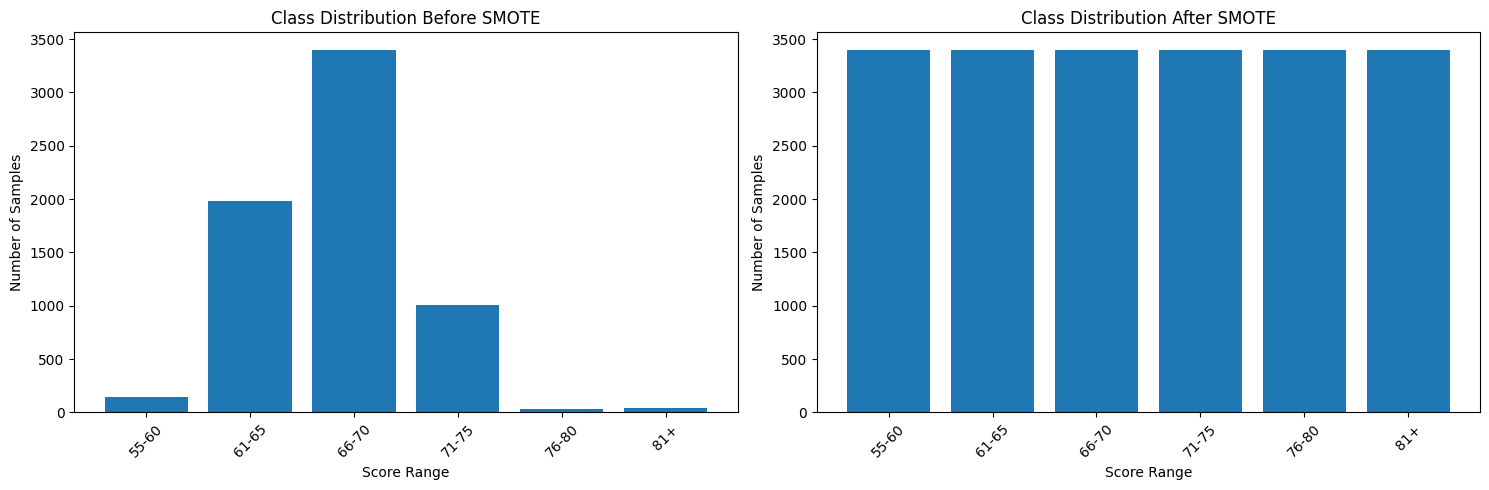

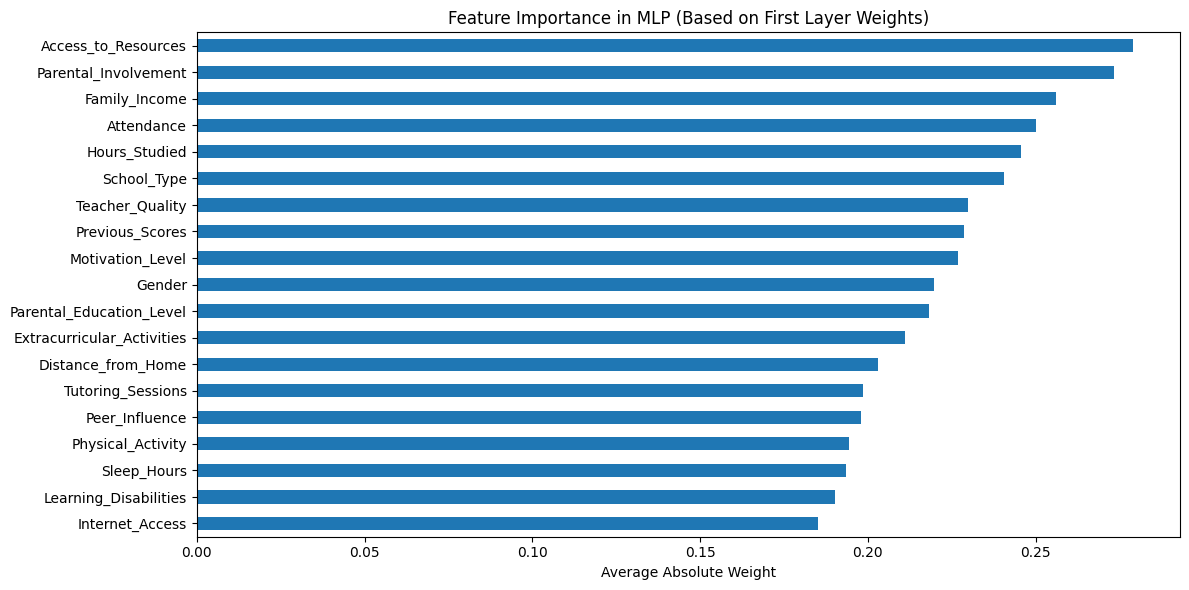

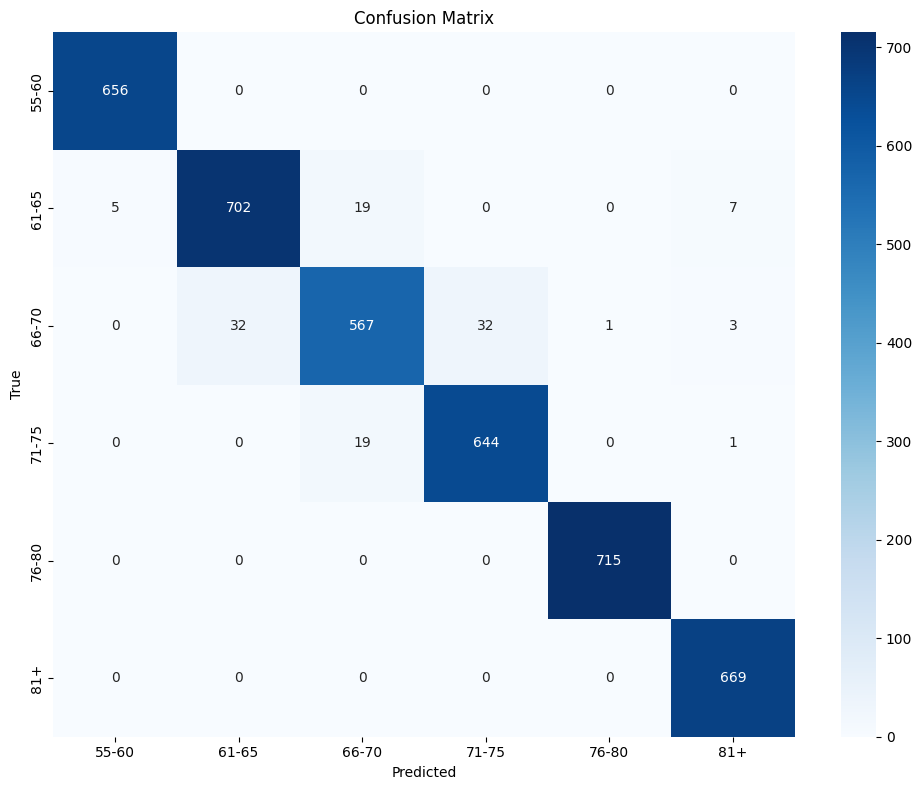

In [21]:
# Generate plots
plot_class_distribution()
plot_feature_importance()
plot_confusion_matrix()